In [3]:
from utils import * 
from stn import SpatialTransformer 
import torch 
from torch import optim
from torch import nn

In [4]:
device = 'cpu' # Use cpu because grid sampler backwards function is not implemented for mps backend 

def test(model): 
    model.eval()

    test_loss = [] 
    
    for transformed, original in zip(test_augment, test_base): 
        transformed = transformed[0].to(device)
        original = original[0].to(device)

        with torch.no_grad():
            output = model(transformed)            

        loss = criterion(output, original)
        test_loss.append(loss.item())
    model.train()
    test_loss = np.array(test_loss)
    return np.mean(test_loss)

stn = SpatialTransformer().to(device)
optimizer = optim.Adam(stn.parameters(), lr=1e-3)
criterion = nn.MSELoss()
train_loss = []
test_loss = [test(stn)]
EPOCHS = 20
stn.train()
for epoch in range(EPOCHS):
    for (transformed_images, _), (original_images, _) in tqdm(zip(train_augment, train_base), total=len(train_augment), desc=f"{epoch+1:02d}/{EPOCHS}"):
        transformed_images = transformed_images.to(device)
        original_images = original_images.to(device)

        optimizer.zero_grad()
        output = stn(transformed_images)
        loss = criterion(output, original_images)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    test_loss.append(test(stn))

KeyboardInterrupt: 

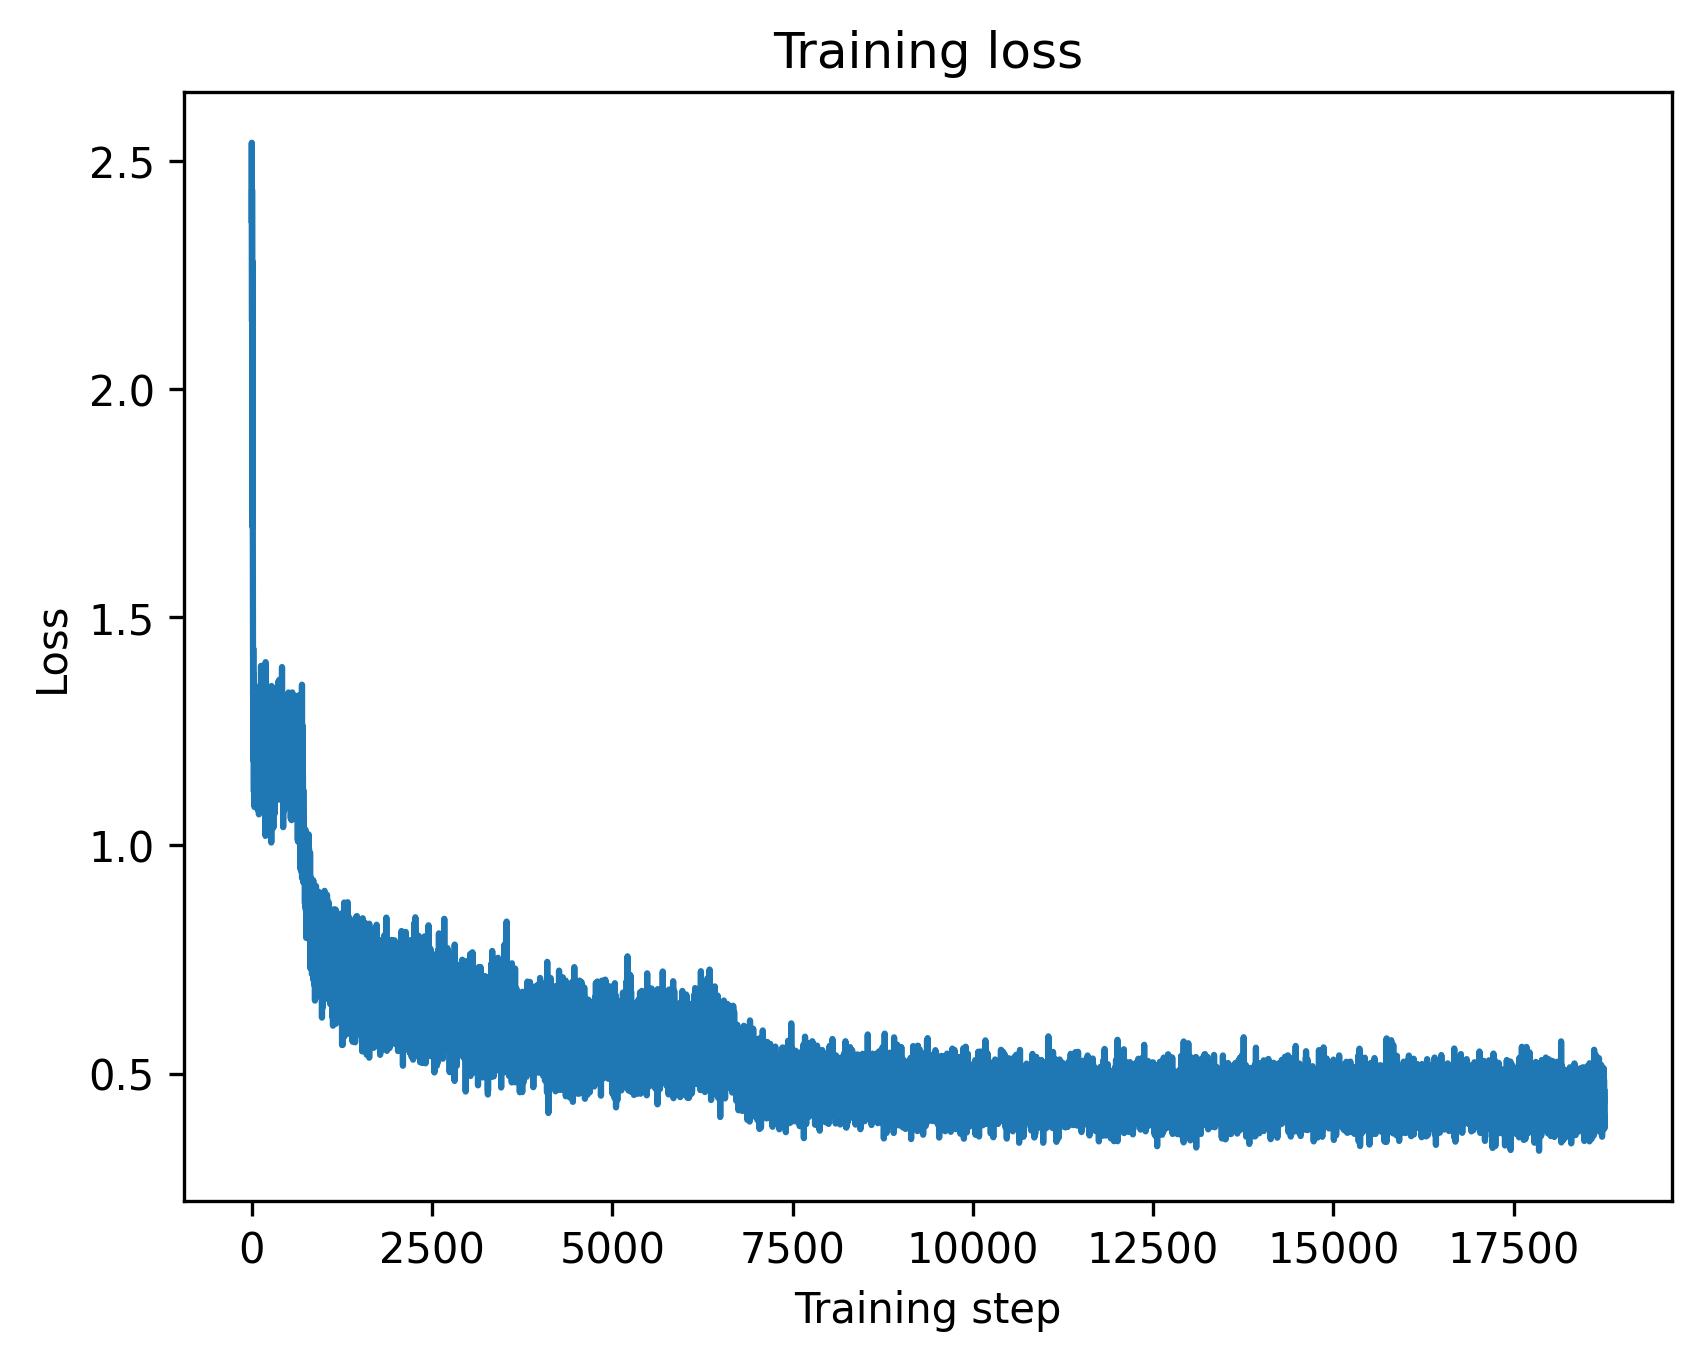

In [ ]:
plt.plot(train_loss)
plt.title("Training loss")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.show()

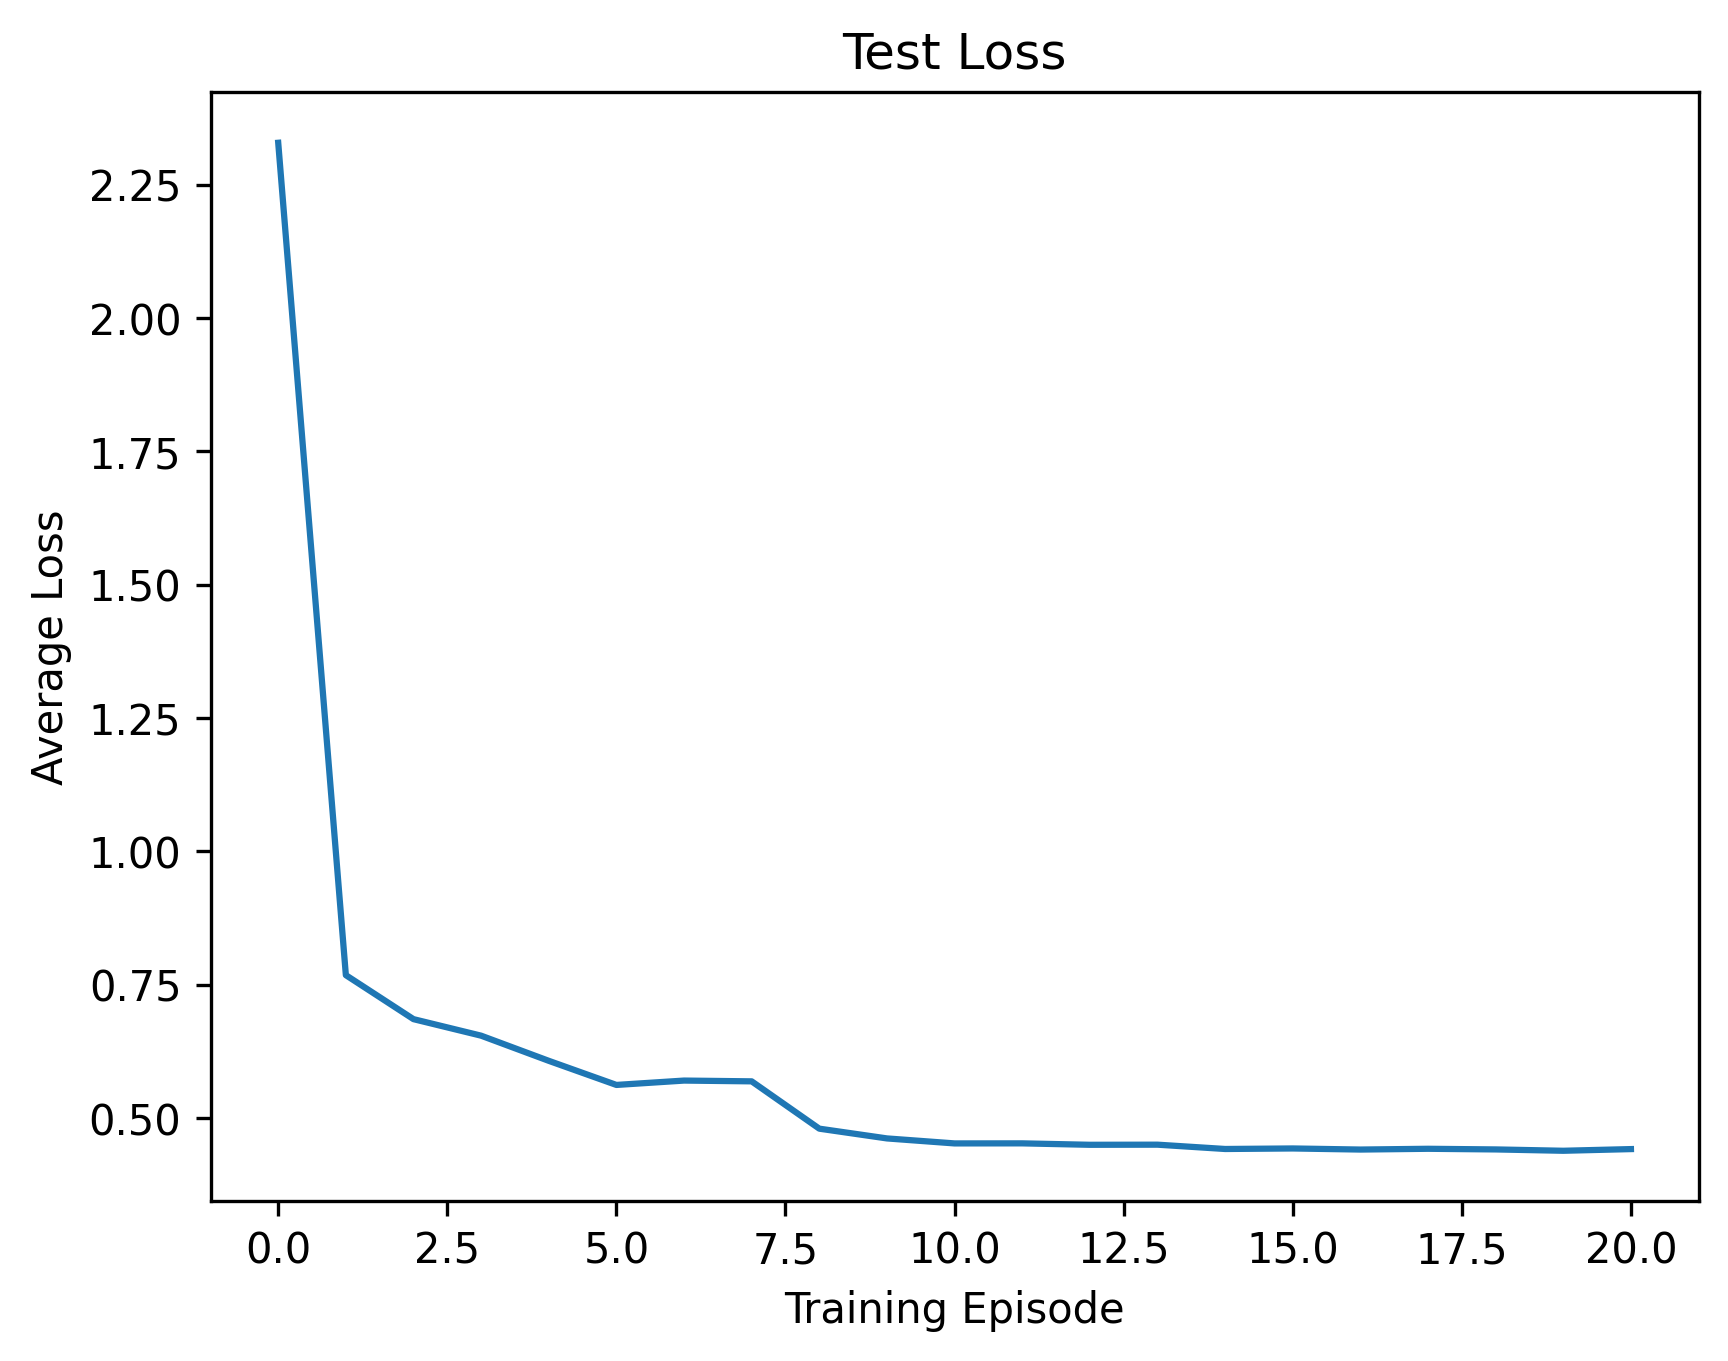

In [ ]:
plt.plot(test_loss)
plt.title("Test Loss")
plt.xlabel("Training Episode")
plt.ylabel("Average Loss")
plt.show()

/Users/henrywilliams/Documents/uni/amml/lab5/.venv/lib/python3.11/site-packages/torch/nn/functional.py:4969: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/henrywilliams/Documents/uni/amml/lab5/.venv/lib/python3.11/site-packages/torch/nn/functional.py:4902: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


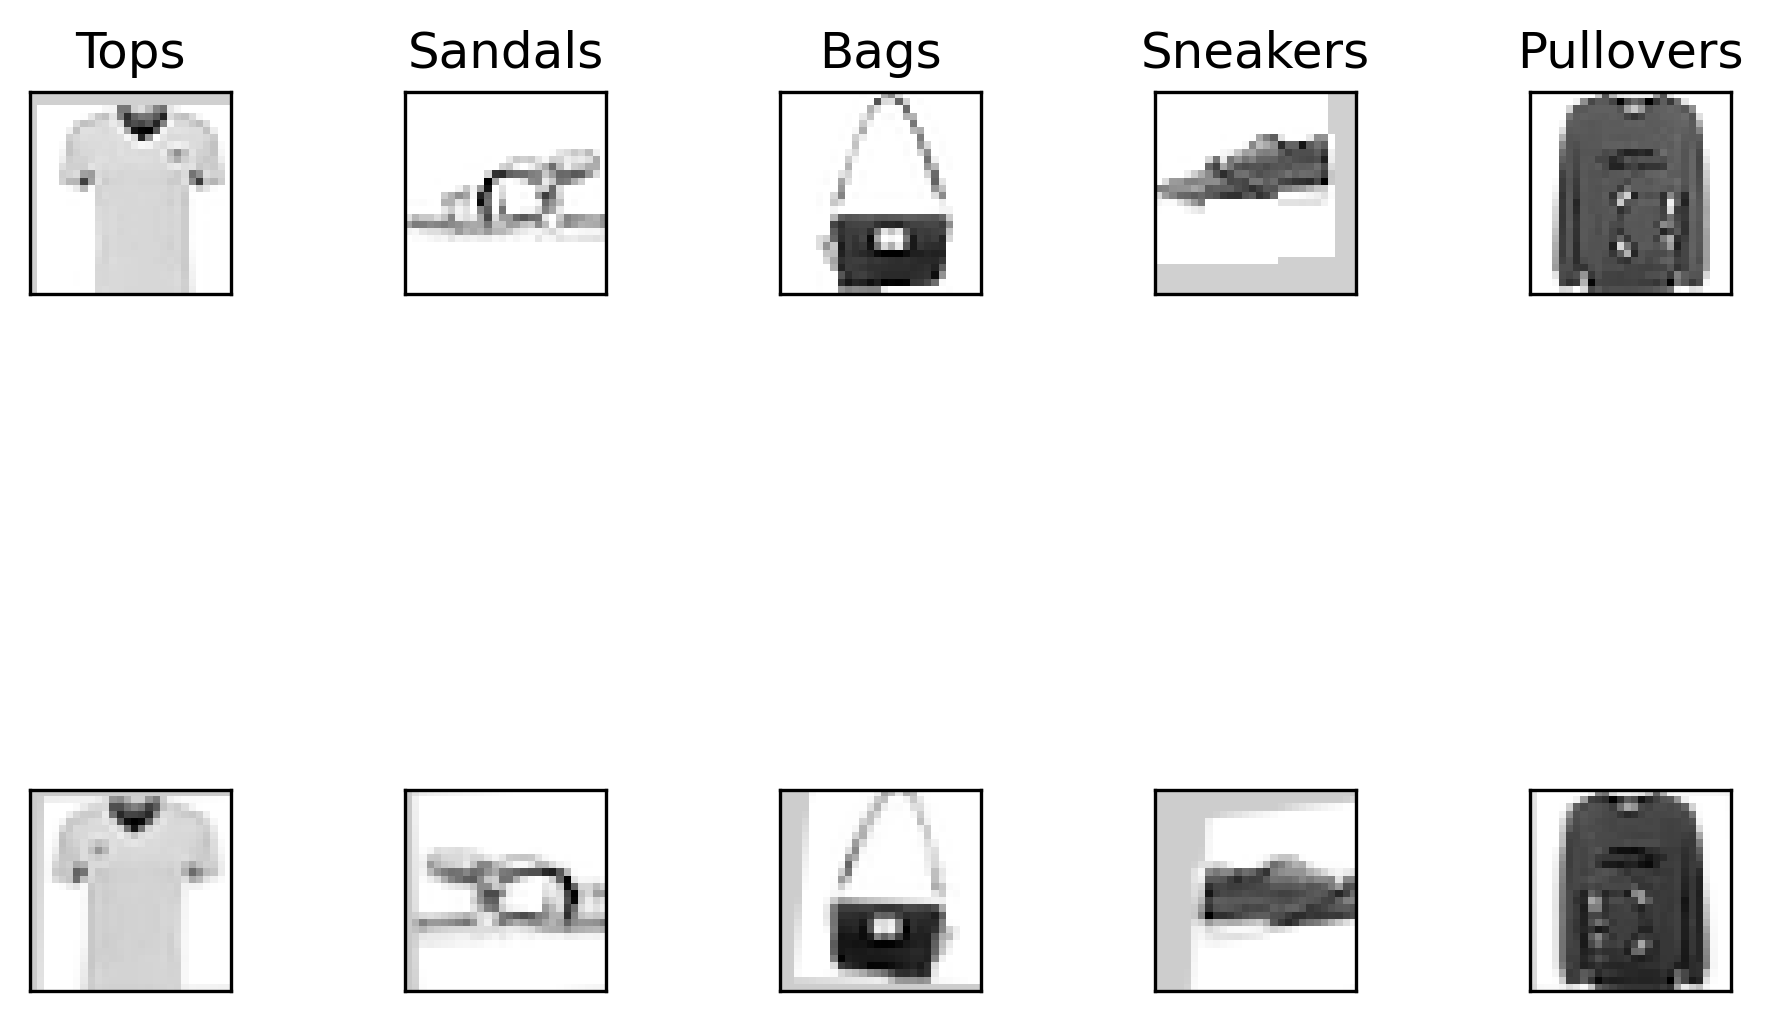

In [10]:
stn = SpatialTransformer().to(device)
stn.load_state_dict(torch.load("/Users/henrywilliams/Documents/uni/amml/lab5/src/trained-stn.pt", weights_only=True))
stn.eval()
fig, axs = plt.subplots(2, 5)
batch = next(iter(test_augment))
plt.tight_layout()

for i in range(5):
    idx = np.random.randint(0, 64)
    label = batch[1][idx]
    sample = batch[0][idx]
    recons = stn(sample.reshape(1, 1, 28, 28)).cpu().detach()
    axs[0][i].title.set_text(CLASSES[label])
    axs[0][i].imshow(sample.reshape(28, 28, 1), cmap="Grays")
    axs[0][i].set_xticks([])
    axs[0][i].set_yticks([])
    axs[1][i].imshow(recons.reshape(28, 28, 1), cmap="Grays")
    axs[1][i].set_xticks([])
    axs[1][i].set_yticks([])


In [ ]:
torch.save(stn.state_dict(), "trained-stn.pt")